<a target="_blank" href="https://colab.research.google.com/github/thierrymoudiki/sktime/blob/nnetsauce-mts/examples/nnetsauce/2024-09-22-nnetsauce-MTS-example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip uninstall sktime -y

Found existing installation: sktime 0.32.1
Uninstalling sktime-0.32.1:
  Successfully uninstalled sktime-0.32.1


In [ ]:
!pip install git+https://github.com/thierrymoudiki/sktime.git --upgrade --no-cache-dir

  Cloning https://github.com/thierrymoudiki/sktime.git (to revision nnetsauce-mts) to /tmp/pip-req-build-y__2br8l
  Running command git clone --filter=blob:none --quiet https://github.com/thierrymoudiki/sktime.git /tmp/pip-req-build-y__2br8l
  Running command git checkout -b nnetsauce-mts --track origin/nnetsauce-mts
  Switched to a new branch 'nnetsauce-mts'
  Branch 'nnetsauce-mts' set up to track remote branch 'nnetsauce-mts' from 'origin'.
  Resolved https://github.com/thierrymoudiki/sktime.git to commit f6edaea63e5fbd54b8f8075f3474fbf8e8a82b4d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sktime: filename=sktime-0.32.1-py3-none-any.whl size=29425467 sha256=312fd730ebd9d8ce93263d841f7bccc8b78ff63e3934357b6a08bbeba6fd67c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-y327n5kd/wheels/8f/6f/81/505b6cf562ee44b6a30237eba488bd229778175235b27d5e95
Successfully built sktime


## Example 1

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import linear_model
from statsmodels.tsa.base.datetools import dates_from_str

from sktime.forecasting.nnetsaucemts import NnetsauceMTS

In [5]:
# some example data
mdata = sm.datasets.macrodata.load_pandas().data
# prepare the dates index
dates = mdata[["year", "quarter"]].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)
mdata = mdata[["realgovt", "tbilrate", "cpi"]]
mdata.index = pd.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

n = data.shape[0]
max_idx_train = np.floor(n * 0.9)
training_index = np.arange(0, max_idx_train)
testing_index = np.arange(max_idx_train, n)
df_train = data.iloc[training_index, :]
print(df_train.tail())
df_test = data.iloc[testing_index, :]

            realgovt  tbilrate  cpi
2003-06-30      0.05     -0.17 0.00
2003-09-30      0.00     -0.02 0.01
2003-12-31      0.01     -0.04 0.01
2004-03-31      0.01      0.04 0.01
2004-06-30      0.01      0.25 0.01


In [6]:
# Adjust Ridge
regr = linear_model.Ridge()
obj_MTS = NnetsauceMTS(
    regr, lags=25, a=0.1, n_hidden_features=5, verbose=1, type_pi="gaussian"
)
display(obj_MTS.get_params())

{'a': 0.1,
 'activation_name': 'relu',
 'agg': 'mean',
 'backend': 'cpu',
 'bias': True,
 'block_size': None,
 'cluster_encode': True,
 'direct_link': True,
 'dropout': 0,
 'kernel': 'gaussian',
 'lags': 25,
 'n_clusters': 2,
 'n_hidden_features': 5,
 'nodes_sim': 'sobol',
 'obj': Ridge(),
 'replications': None,
 'seed': 123,
 'show_progress': True,
 'type_clust': 'kmeans',
 'type_pi': 'gaussian',
 'type_scaling': ('std', 'std', 'std'),
 'verbose': 1,
 'obj__alpha': 1.0,
 'obj__copy_X': True,
 'obj__fit_intercept': True,
 'obj__max_iter': None,
 'obj__positive': False,
 'obj__random_state': None,
 'obj__solver': 'auto',
 'obj__tol': 0.0001}

In [7]:
obj_MTS.fit(df_train)


 Adjusting Ridge to multivariate time series... 
 


100%|██████████| 3/3 [00:00<00:00, 164.21it/s]


NnetsauceMTS(a=0.1, lags=25, obj=Ridge(), type_pi='gaussian', verbose=1)

In [8]:
res = obj_MTS.predict(fh=[i for i in range(1, 10)])
print(res)

            realgovt  tbilrate  cpi
date                               
2004-09-30      0.01      0.12 0.01
2004-12-31      0.02      0.01 0.02
2005-03-31      0.00      0.23 0.01
2005-06-30     -0.00      0.11 0.02
2005-09-30      0.02      0.11 0.02
2005-12-31      0.01      0.15 0.02
2006-03-31     -0.00     -0.04 0.02
2006-06-30      0.01      0.06 0.02
2006-09-30      0.01      0.05 0.02


In [9]:
res = obj_MTS.predict_quantiles(fh=[i for i in range(1, 10)], alpha=0.05)
print(res)

           realgovt tbilrate  cpi realgovt tbilrate  cpi
               0.05     0.05 0.05     0.95     0.95 0.95
date                                                    
2004-09-30    -0.01    -0.06 0.00     0.04     0.31 0.02
2004-12-31    -0.00    -0.18 0.01     0.05     0.19 0.02
2005-03-31    -0.02     0.05 0.01     0.03     0.41 0.02
2005-06-30    -0.03    -0.07 0.01     0.02     0.30 0.02
2005-09-30    -0.01    -0.07 0.01     0.04     0.29 0.02
2005-12-31    -0.02    -0.04 0.02     0.04     0.33 0.03
2006-03-31    -0.03    -0.22 0.01     0.02     0.15 0.02
2006-06-30    -0.02    -0.13 0.01     0.03     0.24 0.03
2006-09-30    -0.02    -0.13 0.01     0.03     0.23 0.03


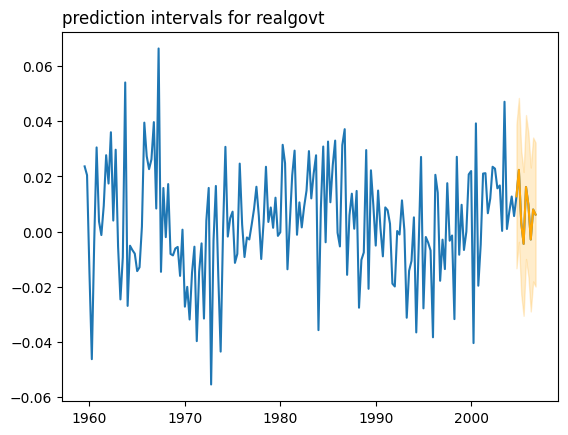

In [10]:
obj_MTS.fitter.plot(series="realgovt")

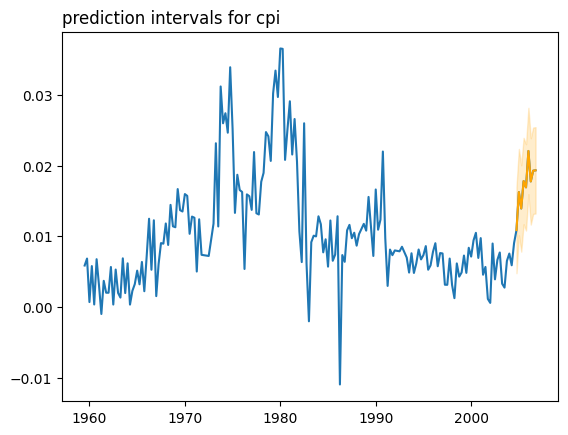

In [11]:
obj_MTS.fitter.plot(series="cpi")

## Example 2

In [12]:
!pip install git+https://github.com/Techtonique/mlsauce.git --upgrade --no-cache-dir

  Cloning https://github.com/Techtonique/mlsauce.git to /tmp/pip-req-build-xpsp999g
  Running command git clone --filter=blob:none --quiet https://github.com/Techtonique/mlsauce.git /tmp/pip-req-build-xpsp999g
  Resolved https://github.com/Techtonique/mlsauce.git to commit d38514c0129c9941cbb8af91b195226362250d80
  Preparing metadata (setup.py) ... done


In [13]:
url = "https://raw.githubusercontent.com/Techtonique/"
url += "datasets/main/time_series/multivariate/"
url += "ice_cream_vs_heater.csv"
df_temp = pd.read_csv(url)
df_temp.index = pd.DatetimeIndex(df_temp.date)  # must have# first other difference
df_icecream = df_temp.drop(columns=["date"]).diff().dropna()

In [14]:
import mlsauce as ms

regr = ms.RidgeRegressor(reg_lambda=100)
obj_MTS = NnetsauceMTS(
    regr,
    lags=25,
    n_hidden_features=3,
    verbose=1,
    type_pi="scp2-kde",
    replications=250,
    kernel="tophat",
)
display(obj_MTS.get_params())
obj_MTS.fit(df_icecream)
res = obj_MTS.predict(fh=[i for i in range(1, 25)])
display(res)
res = obj_MTS.predict_quantiles(fh=[i for i in range(1, 25)], alpha=0.10)
display(res)

{'a': 0.01,
 'activation_name': 'relu',
 'agg': 'mean',
 'backend': 'cpu',
 'bias': True,
 'block_size': None,
 'cluster_encode': True,
 'direct_link': True,
 'dropout': 0,
 'kernel': 'tophat',
 'lags': 25,
 'n_clusters': 2,
 'n_hidden_features': 3,
 'nodes_sim': 'sobol',
 'obj': RidgeRegressor(reg_lambda=100),
 'replications': 250,
 'seed': 123,
 'show_progress': True,
 'type_clust': 'kmeans',
 'type_pi': 'scp2-kde',
 'type_scaling': ('std', 'std', 'std'),
 'verbose': 1,
 'obj__backend': 'cpu',
 'obj__reg_lambda': 100}


 Adjusting RidgeRegressor to multivariate time series... 
 


100%|██████████| 2/2 [00:00<00:00, 246.69it/s]


 Simulate residuals using tophat kernel... 




 Best parameters for tophat kernel: {'bandwidth': 3.3380276739903008} 



100%|██████████| 250/250 [00:00<00:00, 3074.08it/s]


,heater,icecream
date,,
2020-07-01,-0.69,0.23
2020-08-01,0.92,-10.53
2020-09-01,7.04,-15.50
2020-10-01,11.43,-6.55
2020-11-01,8.52,-2.76
2020-12-01,0.05,1.21
2021-01-01,-3.96,1.43
2021-02-01,-9.87,4.00
2021-03-01,-10.65,2.56


100%|██████████| 250/250 [00:00<00:00, 5787.07it/s]


,heater,icecream,heater,icecream
,0.10,0.10,0.90,0.90
date,,,,
2020-07-01,-5.91,-8.17,4.89,9.74
2020-08-01,-4.66,-20.32,6.59,-0.29
2020-09-01,1.31,-25.77,12.37,-4.89
2020-10-01,6.12,-16.69,16.98,4.09
2020-11-01,3.17,-13.80,14.41,7.75
2020-12-01,-5.65,-8.05,6.05,10.60
2021-01-01,-9.54,-7.85,2.22,11.28
2021-02-01,-14.83,-6.44,-4.69,14.44


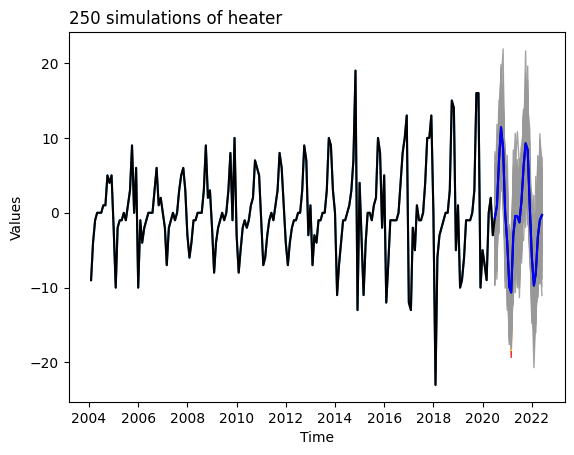

In [15]:
obj_MTS.fitter.plot(series="heater", type_plot="spaghetti")

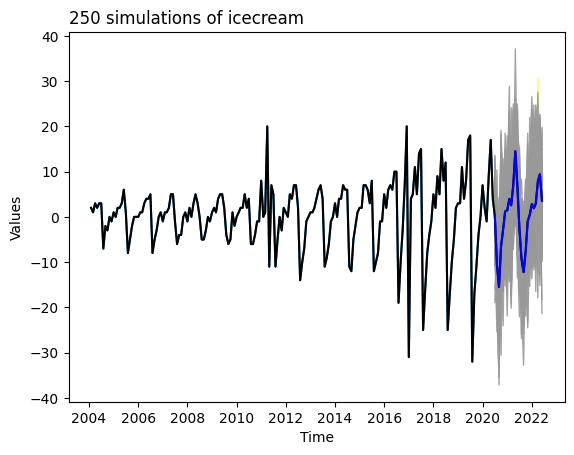

In [16]:
obj_MTS.fitter.plot(series="icecream", type_plot="spaghetti")